In [73]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [9]:
data_src = [
    { 
        'crypto': 'BTC',
        'aave': "../data/aave_data/Core Market/Wrapped BTC.csv",
        'polyio': "../data/polyio_data/adjusted/BTC.csv"
    },
    { 
        'crypto': 'ETH',
        'aave': "../data/aave_data/Core Market/Wrapped ETH.csv",
        'polyio': "../data/polyio_data/adjusted/ETH.csv"
    },
    { 
        'crypto': 'USDC',
        'aave': "../data/aave_data/Core Market/USD Coin.csv",
        'polyio': "../data/polyio_data/adjusted/USDC.csv"
    },
    {
        'crypto': 'USDT',
        'aave': "../data/aave_data/Core Market/Tether.csv",
        'polyio': "../data/polyio_data/adjusted/USDT.csv"
    }
]

In [58]:
def combine_on_datetime(csv_path1, csv_path2):
    df1 = pd.read_csv(csv_path1)
    df2 = pd.read_csv(csv_path2)
    df1['date-time'] = pd.to_datetime(df1['date-time'], utc=False).dt.tz_localize(None)
    df2['date-time'] = pd.to_datetime(df2['date-time'], utc=False).dt.tz_localize(None)
    merged_df = pd.merge(df1, df2, on='date-time', how='inner')
    return merged_df

In [59]:
columns = [
    'date-time', 
    'liquidityRate_avg', 
    'variableBorrowRate_avg', 
    'utilizationRate_avg', 
    'close_price', 
    'volume'
]

In [66]:
data = {
    src['crypto']:
        (combine_on_datetime(src['aave'], src['polyio'])[columns])
        .set_index('date-time')
    for src in data_src
}

data['BTC'].head()

,liquidityRate_avg,variableBorrowRate_avg,utilizationRate_avg,close_price,volume
date-time,,,,,
2023-03-14 00:00:00,0.001406,0.020714,0.084537,24275.71,1411.668208
2023-03-14 01:00:00,0.000307,0.004456,0.084932,24481.00,1280.805261
2023-03-14 02:00:00,0.001008,0.014002,0.089931,24380.52,1395.633094
2023-03-14 03:00:00,0.000449,0.006580,0.078096,24518.10,1179.926761
2023-03-14 04:00:00,0.008074,0.010621,0.070017,24575.21,1262.628515


In [105]:

def train_multivariate_arima(df, column_to_predict, exogenous_columns):
    if column_to_predict not in df.columns:
        raise ValueError(f"Column '{column_to_predict}' does not exist in the dataset")

    for exog in exogenous_columns:
        if exog not in df.columns:
            raise ValueError(f"Exogenous column '{exog}' does not exist in the dataset")

    train_size = int(len(df) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]

    y_train = train[column_to_predict]
    X_train = train[exogenous_columns]

    y_test = test[column_to_predict]
    X_test = test[exogenous_columns]

    model = pm.auto_arima(y_train, exogenous=X_train, seasonal=False, trace=True, suppress_warnings=True)
    print(model.summary())

    forecast = model.predict(n_periods=len(test), exogenous=X_test)
    forecast_series = pd.Series(forecast, index=test.index)
    print(forecast_series)

    rmse = np.sqrt(mean_squared_error(y_test, forecast_series))
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    
    mape = mean_absolute_percentage_error(y_test, forecast_series)
    print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, y_test, label='Actual', color='blue')
    plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red')
    plt.legend()
    plt.title('Multivariate ARIMA Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel(column_to_predict)
    plt.show()

In [106]:
x_cols_for_supply_apy = [
    'variableBorrowRate_avg',
    'utilizationRate_avg',
    'close_price',
    'volume',
]

x_cols_for_borrow_apr = [
    'liquidityRate_avg',
    'utilizationRate_avg',
    'close_price',
    'volume',
]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-65012.768, Time=20.98 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56058.255, Time=2.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59840.859, Time=0.90 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=7.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56060.255, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-64937.106, Time=8.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-65003.456, Time=11.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-65025.260, Time=20.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-64742.087, Time=14.29 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-65046.660, Time=19.60 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-65130.005, Time=34.81 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-62870.132, Time=2.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-64528.735, Time=22.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-62304.143, Time=3.55 sec
 ARIM

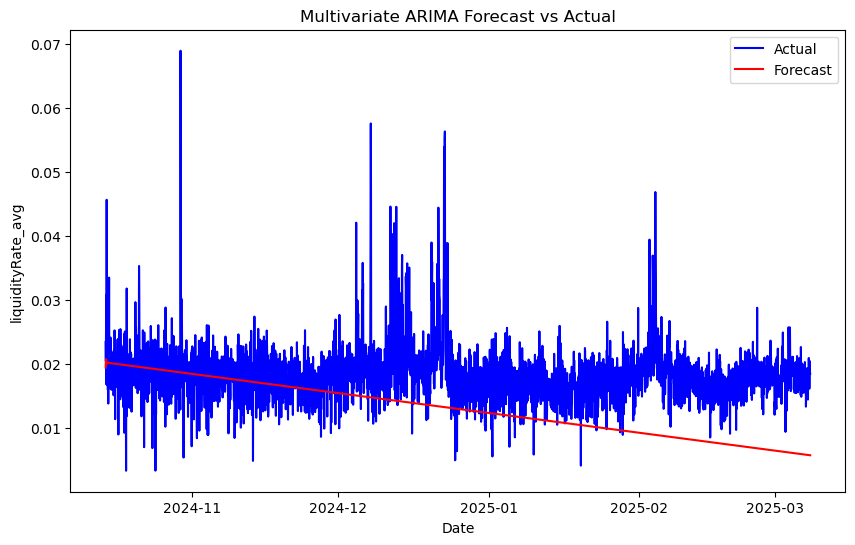

In [108]:
train_multivariate_arima(data['ETH'], 'liquidityRate_avg', x_cols_for_supply_apy)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-89063.911, Time=4.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78373.626, Time=1.47 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-83206.134, Time=1.86 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-88538.697, Time=2.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-78375.626, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-89252.286, Time=5.78 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-89207.789, Time=4.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-89582.989, Time=16.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-89035.612, Time=11.48 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-85653.363, Time=1.92 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-89591.890, Time=2.85 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-89384.116, Time=2.70 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-83208.134, Time=0.63 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-89626.056, Time=4.83 sec
 AR

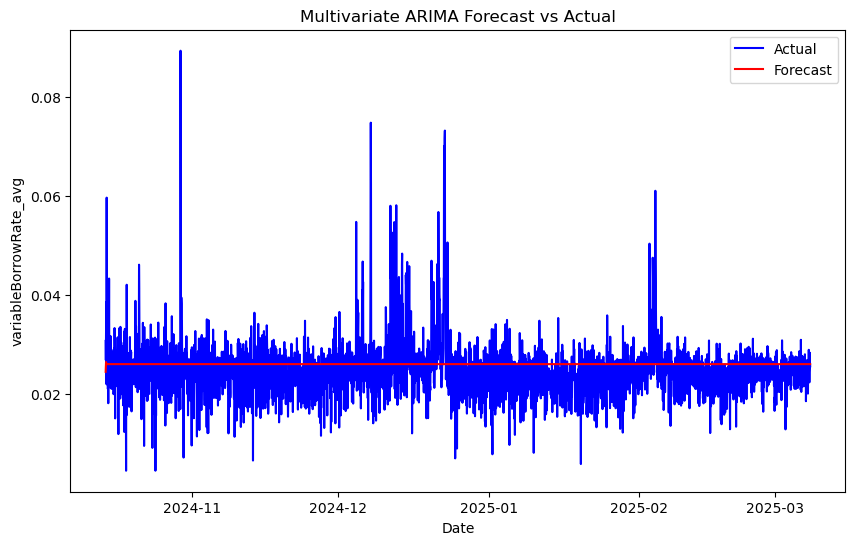

In [109]:
train_multivariate_arima(data['ETH'], 'variableBorrowRate_avg', x_cols_for_borrow_apr)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=3.47 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-49401.191, Time=0.75 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-49401.079, Time=0.32 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-49401.054, Time=0.85 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-49399.972, Time=1.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-49423.878, Time=1.32 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-49423.240, Time=0.70 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-49423.227, Time=1.86 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-49421.561, Time=1.41 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 11.870 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                13924
Model:                        SARIMAX   Log Likelihood               24713.939
Date:                Wed, 19 Mar 2025

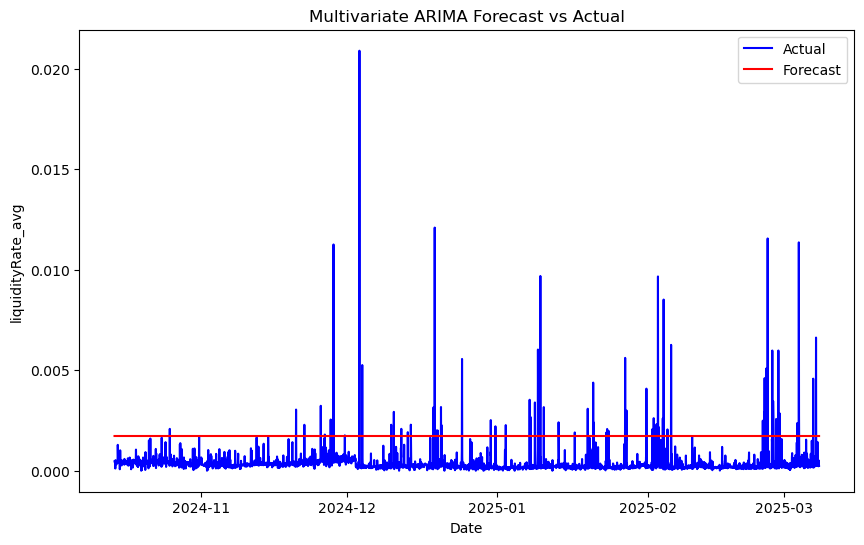

In [110]:
train_multivariate_arima(data['BTC'], 'liquidityRate_avg', x_cols_for_supply_apy)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-102829.746, Time=11.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-94834.617, Time=1.62 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-97396.789, Time=2.78 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-100311.805, Time=2.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94836.616, Time=0.74 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-102140.925, Time=9.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-101337.680, Time=3.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-102923.825, Time=15.90 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-102765.018, Time=13.98 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-102494.226, Time=19.76 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-102634.259, Time=7.00 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-102927.558, Time=8.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-102845.042, Time=5.58 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-101543.134, Time

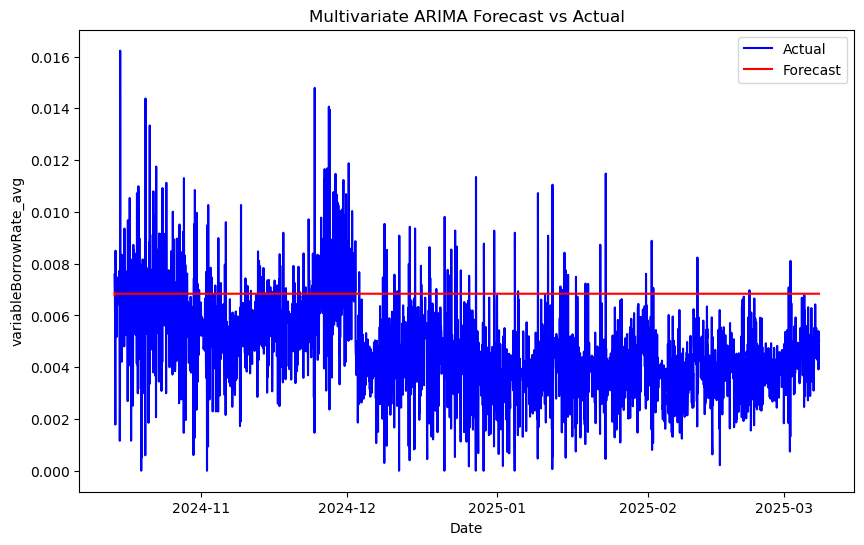

In [111]:
train_multivariate_arima(data['BTC'], 'variableBorrowRate_avg', x_cols_for_borrow_apr)

In [115]:
data['USDT']

,liquidityRate_avg,variableBorrowRate_avg,utilizationRate_avg,close_price,volume
date-time,,,,,
2023-03-14 00:00:00,0.026841,0.033669,0.885642,1.00450,5.479494e+06
2023-03-14 01:00:00,0.018498,0.023178,0.888167,1.00421,7.850737e+06
2023-03-14 02:00:00,0.011905,0.014973,0.883226,1.00463,7.511133e+06
2023-03-14 03:00:00,0.060175,0.076011,0.878935,1.00520,7.736502e+06
2023-03-14 04:00:00,0.026422,0.034169,0.859224,1.00480,8.454853e+06
...,...,...,...,...,...
2025-03-08 01:00:00,0.034010,0.061198,0.601028,0.99958,1.735686e+07
2025-03-08 02:00:00,0.037170,0.066860,0.601230,0.99956,1.102446e+07
2025-03-08 03:00:00,0.032727,0.058867,0.601232,0.99958,1.479521e+07


In [112]:
train_multivariate_arima(data['USDT'], 'liquidityRate_avg', x_cols_for_supply_apy)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-60136.655, Time=8.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54908.769, Time=1.59 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58203.302, Time=1.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-60108.248, Time=11.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-54910.769, Time=0.75 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-60104.386, Time=7.74 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-60305.005, Time=14.68 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-60146.772, Time=10.76 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-59242.897, Time=1.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-60493.492, Time=15.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-59648.425, Time=1.78 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-60417.963, Time=17.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-60258.233, Time=15.77 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-59800.386, Time=1.64 sec

ValueError: Input contains NaN.

In [116]:
train_multivariate_arima(data['USDT'], 'variableBorrowRate_avg', x_cols_for_borrow_apr)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-53269.411, Time=13.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47458.929, Time=1.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-50945.579, Time=1.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-53239.580, Time=4.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47460.929, Time=0.79 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-53237.459, Time=8.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-53372.300, Time=15.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-53268.987, Time=5.76 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-52144.381, Time=1.81 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-53545.322, Time=19.59 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-52635.178, Time=3.04 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-53533.466, Time=19.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-53380.354, Time=15.77 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-52838.593, Time=1.64 sec


ValueError: Input contains NaN.

In [ ]:
# USDT, USDC --> problem: predicts NaN after some timesteps